In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import scanpy.external as sce

/home/sqjiao/.conda/envs/wanghui/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predata = sc.read_text('./VEN4FS_scaled.data.txt')

In [3]:
predata = sc.AnnData(predata.X.T, obs=predata.var, var=predata.obs)

In [4]:
geneslist = ['HCG17','NUDT4', 'CARD16','WNT5A','ATP8A1','SLC7A2',
     'DNAJA4','C6orf163','NPTX1', 'GRIA4','SLITRK1',
     'INPP5A', 'SETBP1','RXFP1','PCDH9', 'MAP2K1', 
     'COL21A1','PLEKHB2', 'FOS', 'SLC7A14','SLC27A5',
  'RNF41','AC092634.5','LINC01845', 'AC025287.3','AL512590.1',
  'PLA2G12B','SPOCK1','MMD','FAM111A-DT','CAMK1D',
'SYTL2','MEIS2', 'OPTN', 'POU3F1', 'SULF2', 'ADRA1A', 'FAM126B']

In [5]:
adata = predata

In [6]:
adata.obs['Cell name'] = adata.obs.index
adata.obs['celltype'] = adata.obs_names.str.extract(r'^(cVEN|PC|ETPC2|ETPC|TRI)', expand=False)

In [7]:
adata.obs

,Cell name,celltype
PC02,PC02,PC
PC04,PC04,PC
PC06,PC06,PC
PC08,PC08,PC
PC09,PC09,PC
...,...,...
PC66,PC66,PC
cVEN21,cVEN21,cVEN
PC67,PC67,PC
PC68,PC68,PC


In [8]:
def pre(adata, selected_cell_type):
    # 创建一个映射将所有细胞类型映射为 0
    cell_type_mapping = {cell: 0 for cell in adata.obs['celltype'].unique()}
    # 将选定的细胞类型映射为细胞名
    cell_type_mapping[selected_cell_type] = 1
    # 将细胞类型映射应用到数据框中
    adata.obs['new_celltype'] = adata.obs['celltype'].map(cell_type_mapping)

    return adata

In [9]:
pre(adata, 'cVEN')

AnnData object with n_obs × n_vars = 124 × 54817
    obs: 'Cell name', 'celltype', 'new_celltype'

In [10]:
adata.obs['new_celltype'].value_counts()

new_celltype
0    102
1     22
Name: count, dtype: int64

In [11]:
Temporal_data = adata
# # 使用默认整数索引
Temporal_data.obs.reset_index(drop=True, inplace=True)
Temporal_data.obs

,Cell name,celltype,new_celltype
0,PC02,PC,0
1,PC04,PC,0
2,PC06,PC,0
3,PC08,PC,0
4,PC09,PC,0
...,...,...,...
119,PC66,PC,0
120,cVEN21,cVEN,1
121,PC67,PC,0
122,PC68,PC,0


    Cell name celltype  new_celltype
0        PC02       PC             0
1        PC04       PC             0
2        PC06       PC             0
3        PC08       PC             0
4        PC09       PC             0
..        ...      ...           ...
119      PC66       PC             0
120    cVEN21     cVEN             1
121      PC67       PC             0
122      PC68       PC             0
123    cVEN22     cVEN             1

[124 rows x 3 columns]


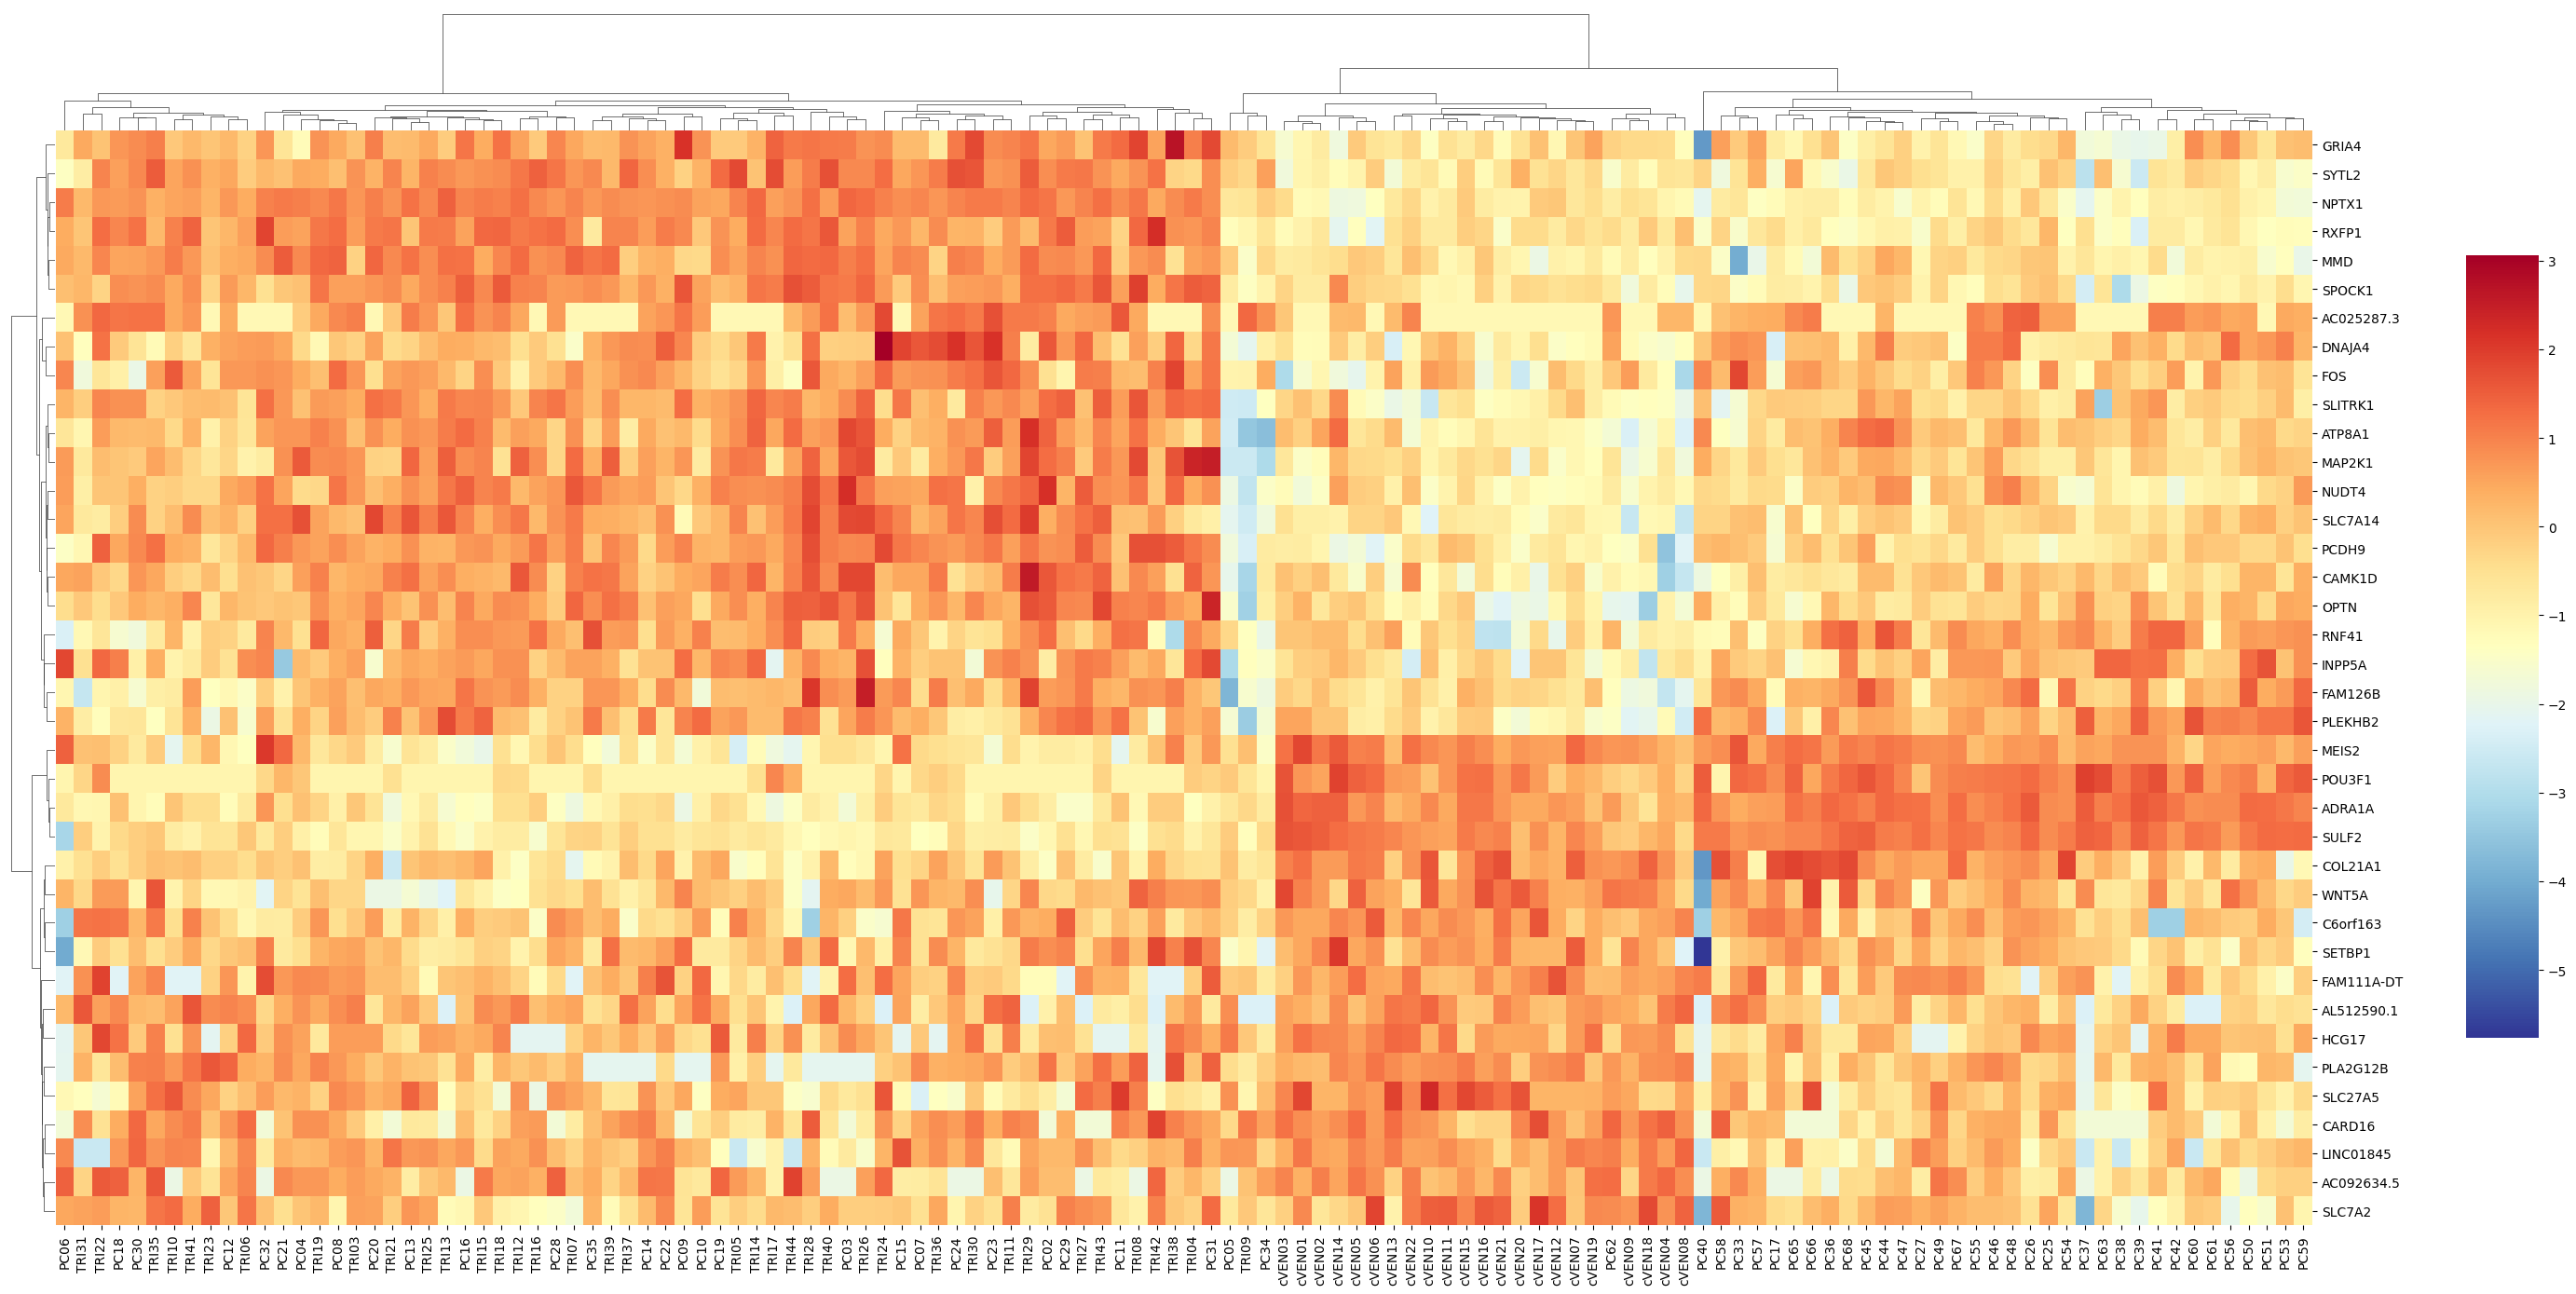

In [12]:

selected_genes_mask1 = Temporal_data.var_names.isin(geneslist)


Temporal_adata_10 = Temporal_data[:, selected_genes_mask1]
print(Temporal_adata_10.obs)

data_exp1 = Temporal_adata_10.X.toarray()
draw_gene1 = Temporal_adata_10.var.index.tolist()
draw_cell1 = Temporal_adata_10.obs['Cell name'].tolist()
df_draw1 = pd.DataFrame(data_exp1, index=draw_cell1, columns=draw_gene1)

clustergrid1 = sns.clustermap(df_draw1.T,col_cluster=True,method='ward',dendrogram_ratio=(0.02, 0.10), cmap='RdYlBu_r', figsize=(26, 14),cbar_pos=(1.02, 0.2, 0.03, 0.6)) # 设置颜色条的位置和大小)#,metric='cosine'


/home/sqjiao/.conda/envs/wanghui/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


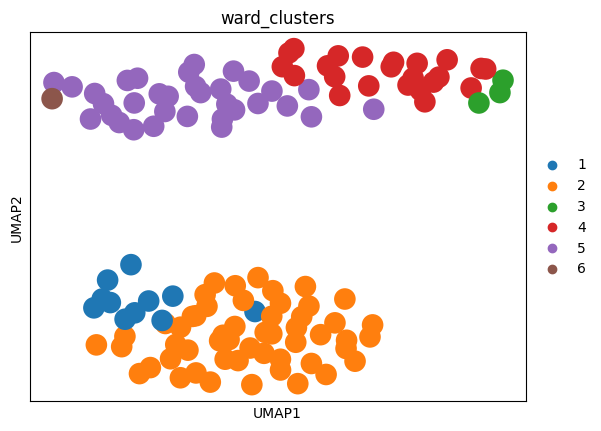

In [13]:
import scipy.cluster.hierarchy as sch
sc.pp.neighbors(Temporal_adata_10, n_neighbors=15)
sc.tl.umap(Temporal_adata_10)
Z = sch.linkage(df_draw1, method='ward')
cluster_labels = sch.fcluster(Z, t=6, criterion='maxclust')
Temporal_adata_10.obs['ward_clusters'] = cluster_labels.astype(str)
sc.pl.umap(Temporal_adata_10, color=['ward_clusters'])

/tmp/ipykernel_4028467/2971082610.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(Temporal_adata_10, key_added="leiden_all", resolution=1.5)


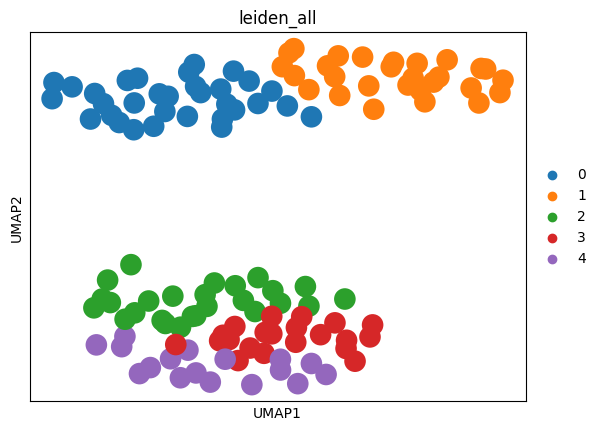

In [14]:
sc.pp.neighbors(Temporal_adata_10, n_neighbors=15)
sc.tl.umap(Temporal_adata_10)
sc.tl.leiden(Temporal_adata_10, key_added="leiden_all", resolution=1.5)
sc.pl.umap(Temporal_adata_10, color="leiden_all", show=False)
plt.show()